# === ЗАДАЧА 1 ===

## 1. Импорты

In [4]:
import re
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt

## 2. Загрузка стихотворений

In [5]:
DATA_DIR = Path("data")
assert DATA_DIR.exists(), "Папка data не найдена"

texts = []
for file in DATA_DIR.glob("*.txt"):
    with open(file, "r", encoding="utf-8") as f:
        texts.append(f.read())

print(f"Загружено документов: {len(texts)}")
print("Пример:\n", texts[0][:500])

Загружено документов: 913
Пример:
 А в ненастные дни
Собирались они
Часто.
Гнули, <- - - -> их <- - ->!
От пятидесяти
На сто.
И выигрывали
И отписывали
Мелом.
Так в ненастные дни
Занимались они
Делом.


## 3. Претокенизация (GPT2)

In [6]:
PRETOKEN_REGEX = re.compile(
    r"[A-Za-zА-Яа-яЁё]+|\d+|[^\w\s]",
    re.UNICODE
)

def pretokenize(text):
    return PRETOKEN_REGEX.findall(text.lower())

## 4. Специальные токены

In [7]:
SPECIAL_TOKENS = ["<PAD>", "<UNK>", "<BOS>", "<EOS>"]

## 5. Инициализация BPE

In [8]:
def get_initial_vocab(tokens):
    vocab = Counter()
    for tok in tokens:
        chars = list(tok)
        chars.append("</w>")
        vocab[tuple(chars)] += 1
    return vocab

## 6. Подсчёт частот пар

In [9]:
def get_pair_stats(vocab):
    pair_freq = Counter()
    for word, freq in vocab.items():
        for i in range(len(word) - 1):
            pair_freq[(word[i], word[i + 1])] += freq
    return pair_freq

## 7. BPE merge

In [10]:
def merge_pair(pair, vocab):
    new_vocab = {}
    a, b = pair
    for word, freq in vocab.items():
        new_word = []
        i = 0
        while i < len(word):
            if i < len(word) - 1 and word[i] == a and word[i + 1] == b:
                new_word.append(a + b)
                i += 2
            else:
                new_word.append(word[i])
                i += 1
        new_vocab[tuple(new_word)] = freq
    return new_vocab

## 8. Обучение токенизатора

In [11]:
def train_bpe(texts, num_merges=5000):
    tokens = []
    for text in texts:
        tokens.extend(pretokenize(text))

    vocab = get_initial_vocab(tokens)
    merges = []

    for i in range(num_merges):
        pair_stats = get_pair_stats(vocab)
        if not pair_stats:
            break
        best_pair = pair_stats.most_common(1)[0][0]
        vocab = merge_pair(best_pair, vocab)
        merges.append(best_pair)

        if i % 500 == 0:
            print(f"BPE step {i}")

    return vocab, merges

## 9. Обучение на стихах

In [12]:
VOCAB, MERGES = train_bpe(texts, num_merges=3000)
print("Число BPE merge:", len(MERGES))

BPE step 0
BPE step 500
BPE step 1000
BPE step 1500
BPE step 2000
BPE step 2500
Число BPE merge: 3000


## 10. Токенизация нового текста

In [13]:
def tokenize_word(word, merges):
    symbols = list(word) + ["</w>"]
    for a, b in merges:
        i = 0
        new_symbols = []
        while i < len(symbols):
            if i < len(symbols) - 1 and symbols[i] == a and symbols[i + 1] == b:
                new_symbols.append(a + b)
                i += 2
            else:
                new_symbols.append(symbols[i])
                i += 1
        symbols = new_symbols
    return symbols

def tokenize_text(text, merges):
    tokens = pretokenize(text)
    output = []
    for tok in tokens:
        output.extend(tokenize_word(tok, merges))
    return output

## 11. Метрики эффективности токенизации

In [14]:
def compression_ratio(text, tokens):
    return len(tokens) / len(text.encode("utf-8"))

def avg_tokens_per_word(text, tokens):
    words = pretokenize(text)
    return len(tokens) / len(words)

## 12. Анализ на другом домене

In [12]:
with open('article.txt', 'r', encoding='utf-8') as file:
    test_text = file.read()

tokens_test = tokenize_text(test_text, MERGES)

print("Compression ratio:", compression_ratio(test_text, tokens_test))
print("Avg tokens per word:", avg_tokens_per_word(test_text, tokens_test))

Compression ratio: 0.1995966944762959
Avg tokens per word: 2.6851063829787236


## 13. Частотные слова (top 10%)

In [13]:
all_words = []
for t in texts:
    all_words.extend(pretokenize(t))

freq = Counter(all_words)
top_10_percent = set(w for w, _ in freq.most_common(len(freq)//10))

def avg_tokens_top_words(words, merges):
    tok_count = 0
    for w in words:
        tok_count += len(tokenize_word(w, merges))
    return tok_count / len(words)

print(
    "Avg tokens for top 10% words:",
    avg_tokens_top_words(list(top_10_percent), MERGES)
)

Avg tokens for top 10% words: 1.6873815839333082


## 14. Кривая vocab size / compression ratio

BPE step 0
BPE step 0
BPE step 500
BPE step 0
BPE step 500
BPE step 1000
BPE step 0
BPE step 500
BPE step 1000
BPE step 1500
BPE step 0
BPE step 500
BPE step 1000
BPE step 1500
BPE step 2000
BPE step 0
BPE step 500
BPE step 1000
BPE step 1500
BPE step 2000
BPE step 2500


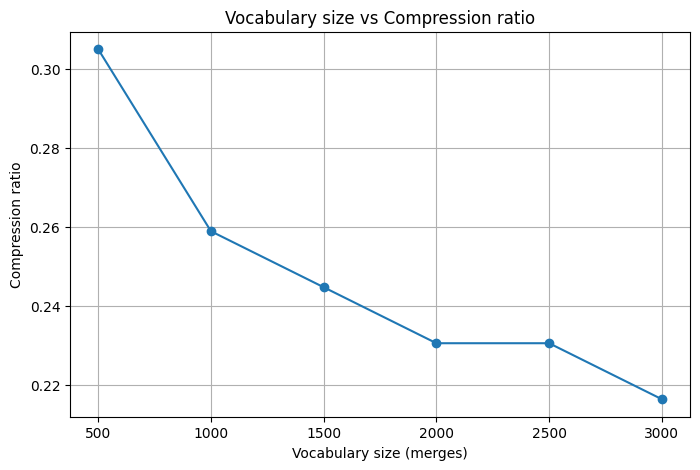

In [14]:
vocab_sizes = []
compression = []

for merges_n in range(500, 3500, 500):
    _, merges_tmp = train_bpe(texts, num_merges=merges_n)
    toks = tokenize_text(texts[0], merges_tmp)
    vocab_sizes.append(merges_n)
    compression.append(compression_ratio(texts[0], toks))

plt.figure(figsize=(8,5))
plt.plot(vocab_sizes, compression, marker='o')
plt.xlabel("Vocabulary size (merges)")
plt.ylabel("Compression ratio")
plt.title("Vocabulary size vs Compression ratio")
plt.grid()
plt.show()

## 15. Неиспользуемые токены

In [15]:
used_tokens = Counter()
for t in texts:
    used_tokens.update(tokenize_text(t, MERGES))

all_tokens = set()
for a, b in MERGES:
    all_tokens.add(a + b)

unused = all_tokens - set(used_tokens.keys())

print(f"Всего токенов: {len(all_tokens)}")
print(f"Не использовано ни разу: {len(unused)}")
print(f"Доля неиспользуемых: {len(unused)/len(all_tokens):.2%}")

Всего токенов: 3000
Не использовано ни разу: 20
Доля неиспользуемых: 0.67%


In [16]:
print(unused)

{'вот', 'гда</w>', 'волше', 'нр', 'слиш', 'равно', 'тот', 'скоре', 'spea', 'оте', 'сквоз', 'уголо', 'epigra', 'всю', 'нрз', 'сю', 'тепер', 'теб', 'очен', 'сего'}


# === ЗАДАЧА 2 ===

## 1. Импорты

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

## 2. Подготовка словаря

In [15]:
bpe_tokens = set()
for a, b in MERGES:
    bpe_tokens.add(a)
    bpe_tokens.add(b)
    bpe_tokens.add(a + b)

SPECIAL = ["<PAD>", "<UNK>", "<BOS>", "<EOS>"]
bpe_tokens = SPECIAL + sorted(bpe_tokens)

token2id = {tok: i for i, tok in enumerate(bpe_tokens)}
id2token = {i: tok for tok, i in token2id.items()}

VOCAB_SIZE = len(token2id)
print("Vocab size:", VOCAB_SIZE)

Vocab size: 3083


## 3. Кодирование текста в id

In [16]:
def encode_text(text, merges):
    tokens = tokenize_text(text, merges)
    ids = [token2id.get(t, token2id["<UNK>"]) for t in tokens]
    return ids

## 4. Датасет для language modeling

In [17]:
class LMDataset(Dataset):
    def __init__(self, texts, merges, seq_len=32):
        self.seq_len = seq_len
        all_ids = []
        for t in texts:
            all_ids.extend(
                [token2id["<BOS>"]] +
                encode_text(t, merges) +
                [token2id["<EOS>"]]
            )
        self.data = torch.tensor(all_ids, dtype=torch.long)

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+1:idx+self.seq_len+1]
        return x, y

## 5. DataLoader

In [18]:
SEQ_LEN = 32
BATCH_SIZE = 64

dataset = LMDataset(texts, MERGES, seq_len=SEQ_LEN)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print("Dataset size:", len(dataset))

Dataset size: 240329


## 6. Простая RNN

In [19]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.rnn(emb)
        logits = self.fc(out)
        return logits


## 7. Инициализация модели

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RNN(VOCAB_SIZE).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

RNN(
  (embedding): Embedding(3083, 128)
  (rnn): GRU(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=3083, bias=True)
)


## 8. Обучение

In [21]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x, y in tqdm(loader, desc=f"Epoch {epoch+1}"):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)

        loss = criterion(
            logits.view(-1, VOCAB_SIZE),
            y.view(-1)
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, loss = {total_loss/len(loader):.4f}")

Epoch 1: 100%|██████████| 3756/3756 [10:03<00:00,  6.22it/s]


Epoch 1, loss = 4.0840


Epoch 2: 100%|██████████| 3756/3756 [10:30<00:00,  5.96it/s]


Epoch 2, loss = 2.3898


Epoch 3: 100%|██████████| 3756/3756 [09:51<00:00,  6.35it/s]


Epoch 3, loss = 1.8598


Epoch 4: 100%|██████████| 3756/3756 [11:07<00:00,  5.63it/s]


Epoch 4, loss = 1.6075


Epoch 5: 100%|██████████| 3756/3756 [10:59<00:00,  5.70it/s]

Epoch 5, loss = 1.4557


## 9. Генерация текста / тест

In [22]:
def generate(model, start_text, merges, max_len=50):
    model.eval()
    ids = [token2id["<BOS>"]] + encode_text(start_text, merges)
    x = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(max_len):
            logits = model(x)
            next_id = torch.argmax(logits[0, -1]).item()
            ids.append(next_id)
            x = torch.tensor(ids[-SEQ_LEN:], dtype=torch.long).unsqueeze(0).to(device)

    return " ".join(id2token[i] for i in ids)

In [23]:
print(generate(model, "люблю", MERGES))

<BOS> люблю</w> я</w> ле тали</w> ,</w> обма ны ни</w> об</w> измен не</w> цел е и</w> ,</w> одна</w> свобода</w> :</w> вы</w> скоро</w> ей</w> мне</w> неж ною</w> ,</w> твои</w> хвал ы</w> я</w> ,</w> призна юсь</w> ,</w> я</w> тихий</w> стон</w> ?</w> .</w> .</w> .</w> и</w> буты л ки</w> вмиг</w> за д или</w> !</w> <EOS> <BOS>


# === ЗАДАЧА 3 ===

## 1. Импорт

In [24]:
from transformers import GPT2LMHeadModel

## 2. Подготовка токенизатора

In [25]:
SPECIAL_TOKENS = {
    "pad_token": "<PAD>",
    "bos_token": "<BOS>",
    "eos_token": "<EOS>",
    "unk_token": "<UNK>"
}

PAD_ID = token2id["<PAD>"]
BOS_ID = token2id["<BOS>"]
EOS_ID = token2id["<EOS>"]

## 3. Датасет для GPT2 fine-tuning

In [26]:
class GPT2Dataset(Dataset):
    def __init__(self, texts, merges, seq_len=128):
        all_ids = []
        for text in texts:
            ids = (
                [BOS_ID] +
                encode_text(text, merges) +
                [EOS_ID]
            )
            all_ids.extend(ids)

        self.data = torch.tensor(all_ids, dtype=torch.long)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        return {
            "input_ids": x,
            "labels": x.clone()
        }

## 4. DataLoader

In [ ]:
SEQ_LEN = 128
BATCH_SIZE = 64

dataset = GPT2Dataset(texts, MERGES, seq_len=SEQ_LEN)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

## 5. Загрузка GPT2 и замена словаря

In [29]:
model = GPT2LMHeadModel.from_pretrained(
    "./gpt2_local",
    local_files_only=True
)
model.resize_token_embeddings(len(token2id))
model = model.to(device)

print("GPT-2 vocab resized to:", len(token2id))

GPT-2 vocab resized to: 3083


In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.transformer.wte.parameters():
    param.requires_grad = True

for param in model.lm_head.parameters():
    param.requires_grad = True

## 6. Оптимизатор

In [ ]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-4
)

## 7. Fine-tuning

In [ ]:
from torch.amp import GradScaler, autocast
scaler = GradScaler()

In [ ]:
EPOCHS = 3

model.train()
for epoch in range(EPOCHS):
    total_loss = 0

    for batch in tqdm(loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(
                input_ids=input_ids,
                labels=labels
            )
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: loss = {total_loss / len(loader):.4f}")

## 8. Генерация текста

In [ ]:
def detokenize(tokens):
    text = ""
    for t in tokens:
        while "</w>" in t:
            t = t.replace("</w>", '')
        text += t + " "
    return text.replace("<BOS>", "").replace("<EOS>", "").strip()

In [ ]:
import torch.nn.functional as F

def generate_gpt2(model, prompt, merges, max_len=50, temperature=1.0):
    model.eval()

    ids = [BOS_ID] + encode_text(prompt, merges)
    input_ids = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(max_len):
            outputs = model(input_ids=input_ids)
            logits = outputs.logits[0, -1] / temperature
            probs = F.softmax(logits, dim=-1)

            next_id = torch.multinomial(probs, num_samples=1).item()
            ids.append(next_id)

            if next_id == EOS_ID:
                break

            input_ids = torch.tensor(ids[-SEQ_LEN:], dtype=torch.long).unsqueeze(0).to(device)

    tokens = [id2token[i] for i in ids]
    return detokenize(tokens)

In [ ]:
print(generate_gpt2(model, "Я помню чудное мгновенье", MERGES, temperature=0.8))